# Understanding Hired Rides in NYC

## Project Setup

In [325]:
import math
import statistics
import re
import os
import bs4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas
import requests
import sqlalchemy as db
import warnings

<IPython.core.display.Javascript object>

In [2]:
warnings.filterwarnings("ignore")

In [332]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

<IPython.core.display.Javascript object>

## Part 1: Data Preprocessing

### Calculating distance
Function ```calculate_distance``` will calculate the distance between two geographical points using the points' lattitudes and longitudes by the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula). The obtained distance will then be added to a column named 'distance' by the ```add_distance_column``` function.

In [326]:
def calculate_distance(from_coord, to_coord):
    """Take in two coordinates and return their distance in kilometer.

    Parameters:
    from_coord(list): list containing 2 float
    to_coord(list): the lattitude and longitude of the destination

    Returns:
    float: the distance in kilometer
    """
    # radius of earth in km
    R = 6371

    lat_from = math.radians(from_coord[0])
    lon_from = math.radians(from_coord[1])
    lat_to = math.radians(to_coord[0])
    lon_to = math.radians(to_coord[1])

    # Haversine formula: https://en.wikipedia.org/wiki/Haversine_formula
    dlon = lon_to - lon_from
    dlat = lat_to - lat_from
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat_from) * math.cos(lat_to) * math.sin(dlon / 2) ** 2
    )
    d = 2 * R * math.asin(math.sqrt(a))

    return d

<IPython.core.display.Javascript object>

In [408]:
def add_distance_column(dataframe):
    """Add a column of the distance calculated."""
    # dataframe contains pickup_latitude etc. after column name normalization
    dataframe["distance"] = dataframe.apply(
        lambda x: calculate_distance(
            [x["pickup_latitude"], x["pickup_longitude"]],
            [x["dropoff_latitude"], x["dropoff_longitude"]],
        ),
        axis=1,
    )

<IPython.core.display.Javascript object>

### Processing Taxi Data

The Yellow Taxi Parquet files are programmatically downloaded from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page. The taxi data is cleaned and normalized. Some location data are in the form of the geographical zone ids, and the coordinates of the center point of the zones is used as the coordinates of the location. Missing data in distance is filled up using the coordinates. The data is normalized and cleanned. The trips with pickup or dropoff outside the intended region are also removed.

In [336]:
def find_taxi_csv_urls():
    """Obtain the url of each Yellow Taxi Parque file and return the urls in list."""

    pattern = r"Yellow Taxi Trip Records"
    response = requests.get(TAXI_URL)
    content = response.content
    soup = bs4.BeautifulSoup(content, "html.parser")
    y_urls = [y["href"] for y in soup.find_all(title=pattern)]
    # getting links from 2009-01 to 2015-06
    y_urls = y_urls[-84:]
    urls = [item for idx, item in enumerate(y_urls) if idx not in range(6, 12)]

    return urls

<IPython.core.display.Javascript object>

In [363]:
def get_and_clean_month_taxi_data(url):
    """Get the yellow taxi trip data of each month and return the trip data after cleaning.

    Parameters:
    url(str): The url of the parquet file.

    Returns:
    df: a dataframe containing trip data.
    """

    # download taxi data with url and save as dataframe
    df = pd.read_parquet(url, engine="pyarrow")

    # looking up the latitude and longitude for some months where only location IDs and normalize column names
    pattern1 = r"LocationID"
    pattern2 = r"latitude"
    pattern3 = r"Lat"
    df_type = 0
    for col in df.columns:
        if re.search(pattern1, col):
            df_type = 1  # 2011-01 to 2015-06
        if re.search(pattern2, col):
            df_type = 2  # 2010-01 to 2010-12
        if re.search(pattern3, col):
            df_type = 3  # 2009-01 to 2009-12

    if df_type == 1:
        # load and convert zone data
        zones = geopandas.read_file("taxi_zones.shp")
        zones = zones.to_crs(4326)
        zones["lon"] = zones.centroid.x
        zones["lat"] = zones.centroid.y
        zones = zones[["LocationID", "lon", "lat"]]

        # drop unnecessary columns
        cols = [
            "tpep_pickup_datetime",
            "passenger_count",
            "trip_distance",
            "PULocationID",
            "DOLocationID",
            "fare_amount",
            "tip_amount",
        ]
        df = df[cols]

        # get pickup lattitude and longitude
        df = df.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")
        df.drop(["LocationID"], axis=1, inplace=True)
        df.rename(
            {"lon": "pickup_longitude", "lat": "pickup_latitude"}, axis=1, inplace=True
        )

        # get dropoff lattitude and longitude
        df = df.merge(zones, left_on="DOLocationID", right_on="LocationID", how="left")
        df.drop(["LocationID"], axis=1, inplace=True)
        df.rename(
            {"lon": "dropoff_longitude", "lat": "dropoff_latitude"},
            axis=1,
            inplace=True,
        )

        # remove unnecessary columns
        df.drop(["PULocationID", "DOLocationID"], axis=1, inplace=True)

        # remove nan values
        df.dropna(inplace=True)

        # normalize column names and types
        df.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)

    if df_type == 2:
        cols = [
            "pickup_datetime",
            "passenger_count",
            "trip_distance",
            "pickup_longitude",
            "pickup_latitude",
            "dropoff_longitude",
            "dropoff_latitude",
            "fare_amount",
            "tip_amount",
        ]
        df = df[cols]

    if df_type == 3:
        cols = [
            "Trip_Pickup_DateTime",
            "Passenger_Count",
            "Trip_Distance",
            "Start_Lon",
            "Start_Lat",
            "End_Lon",
            "End_Lat",
            "Fare_Amt",
            "Tip_Amt",
        ]
        df = df[cols]

        # normalize column names and types
        df.rename(
            columns={
                "Trip_Pickup_DateTime": "pickup_datetime",
                "Passenger_Count": "passenger_count",
                "Trip_Distance": "trip_distance",
                "Start_Lon": "pickup_longitude",
                "Start_Lat": "pickup_latitude",
                "End_Lon": "dropoff_longitude",
                "End_Lat": "dropoff_latitude",
                "Fare_Amt": "fare_amount",
                "Tip_Amt": "tip_amount",
            },
            inplace=True,
        )

    # drop nan values
    df.dropna(inplace=True)

    # remove trips out side the designated coordbox (40.560445, -74.242330) and (40.908524, -73.717047)
    df = df[(df["pickup_latitude"] >= 40.560445) & (df["pickup_latitude"] <= 40.908524)]
    df = df[
        (df["pickup_longitude"] >= -74.242330) & (df["pickup_longitude"] <= -73.717047)
    ]
    df = df[
        (df["dropoff_latitude"] >= 40.560445) & (df["dropoff_latitude"] <= 40.908524)
    ]
    df = df[
        (df["dropoff_longitude"] >= -74.242330)
        & (df["dropoff_longitude"] <= -73.717047)
    ]

    # drop 0 passenger trips
    df = df[df["passenger_count"] != 0]

    # drop trips with no fare
    df = df[df["fare_amount"] != 0]

    # drop trips with no distance between dropoff and pickup
    df = df[
        (df["pickup_latitude"] != df["dropoff_latitude"])
        | (df["pickup_longitude"] != df["dropoff_longitude"])
    ]
    df = df[df["trip_distance"] != 0]

    # normalize column types
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

    # sampling 2472 data for each month
    df = df.sample(n=2472)

    # drop unnecessary columns
    df.drop(["trip_distance"], axis=1, inplace=True)
    df.reset_index(drop=True)

    # save to a csv file
    df.to_csv(url, encoding="utf-8", index=False)
    return df

<IPython.core.display.Javascript object>

In [404]:
def get_and_clean_taxi_data():
    """Get and clean the yellow taxi data for all the required month, return it in a whole dataframe"""
    all_taxi_dataframes = []

    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)

        all_taxi_dataframes.append(dataframe)

    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

<IPython.core.display.Javascript object>

### Processing Uber Data

The uber_data is downloaded from https://drive.google.com/file/d/1F7D82w1D5151GXCR6BTEk7mNQ_YnPNDk/view and saved as "uber_rides_sample.csv" locally. The data is normalized and cleanned. The trips with pickup or dropoff outside the intended region are also removed. Trip distance is calculated by the coordinates as well. The mean of the monthly trip numbers is calculated to determine the sample size of the taxi data.

In [405]:
def load_and_clean_uber_data(csv_file):
    """Get the uber trip data of each month and return the trip data after cleaning.

    Parameters:
    csv_file(str): the location of the csv file containting uber data.

    Returns:
    df: a dataframe containing trip data.
    """
    df = pd.read_csv(csv_file)

    # drop OTC in datetime
    new = df["pickup_datetime"].str.split(" ", n=2, expand=True)
    df["pickup_datetime"] = new[0] + " " + new[1]

    # convert to datetime
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

    # remove trips out side the designated coordbox (40.560445, -74.242330) and (40.908524, -73.717047)
    df = df[(df["pickup_latitude"] >= 40.560445) & (df["pickup_latitude"] <= 40.908524)]
    df = df[
        (df["pickup_longitude"] >= -74.242330) & (df["pickup_longitude"] <= -73.717047)
    ]
    df = df[
        (df["dropoff_latitude"] >= 40.560445) & (df["dropoff_latitude"] <= 40.908524)
    ]
    df = df[
        (df["dropoff_longitude"] >= -74.242330)
        & (df["dropoff_longitude"] <= -73.717047)
    ]

    # drop 0 passenger trips
    df = df[df["passenger_count"] != 0]

    # drop trips with no fare
    df = df[df["fare_amount"] != 0]

    # drop trips with no distance between dropoff and pickup
    df = df[
        (df["pickup_latitude"] != df["dropoff_latitude"])
        | (df["pickup_longitude"] != df["dropoff_longitude"])
    ]

    # drop unnecessary columns
    df.drop(["Unnamed: 0", "key"], axis=1, inplace=True)

    # change column order in accordance with taxi data
    column_order = [
        "pickup_datetime",
        "passenger_count",
        "fare_amount",
        "pickup_longitude",
        "pickup_latitude",
        "dropoff_longitude",
        "dropoff_latitude",
    ]
    df = df[column_order]

    return df

<IPython.core.display.Javascript object>

In [406]:
def get_uber_data():
    """load the uber data and add the distance column to it"""
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    print(f"The mean of each month's uber trip is {int(len(uber_dataframe)/78)}.")

    return uber_dataframe

<IPython.core.display.Javascript object>

### Process All Data
Load and process the required datasets.

In [ ]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()

## Part 2: Storing Cleaned Data

Create the SQL tables for the sampled datasets of Yellow Taxi trips and Uber trips. A schema.sql file that defines each table’s schema is created as well. 

In [369]:
engine = db.create_engine(DATABASE_URL)

<IPython.core.display.Javascript object>

In [407]:
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    passenger_count INTEGER,
    fare_amount FLOAT,
    tip_amount FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    passenger_count INTEGER,
    fare_amount FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)
"""

<IPython.core.display.Javascript object>

In [371]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

<IPython.core.display.Javascript object>

In [372]:
with engine.connect() as connection:
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

<IPython.core.display.Javascript object>

### Add Data to Database

Populate tables for the sampled datasets of Yellow Taxi trips and Uber trips from the previously obtained dataframes.

In [373]:
def write_dataframes_to_table(table_to_df_dict):
    """Take in the dictionary mapping tables to names and add data from the corresponding dataframe"""
    for key, value in table_to_df_dict.items():
        value.to_sql(key, con=engine, if_exists="append", index=False)

<IPython.core.display.Javascript object>

In [374]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data
}


<IPython.core.display.Javascript object>

In [375]:
write_dataframes_to_table(map_table_name_to_dataframe)

<IPython.core.display.Javascript object>

## Part 3: Understanding the Data

Define and execute 4 SQL queries related to the data.

In [378]:
def write_query_to_file(query, outfile):
    """Take in the SQL query and write query to .sql file"""
    with open(outfile, "w") as f:
        f.write(query)


<IPython.core.display.Javascript object>

### Query 1

Retreive the most popular hour of the day to take a Yellow Taxi for 01-2009 through 06-2015.


In [379]:
TOP_HOUR_TAXI = """
WITH cte_hourly_taxi_trips AS(
    SELECT 
    strftime('%H',  pickup_datetime) AS hour, 
    COUNT(id) AS trip_counts
    FROM taxi_trips
    GROUP BY hour
)
SELECT * FROM cte_hourly_taxi_trips ORDER BY trip_counts DESC 
"""

<IPython.core.display.Javascript object>

In [380]:
engine.execute(TOP_HOUR_TAXI).fetchall()

[('19', 11999),
 ('18', 11536),
 ('20', 11382),
 ('21', 11025),
 ('22', 10786),
 ('14', 9841),
 ('23', 9788),
 ('17', 9627),
 ('12', 9415),
 ('15', 9314),
 ('13', 9291),
 ('11', 9047),
 ('09', 8794),
 ('08', 8685),
 ('10', 8650),
 ('16', 7898),
 ('00', 7663),
 ('07', 6922),
 ('01', 5697),
 ('02', 4197),
 ('06', 3977),
 ('03', 3062),
 ('04', 2289),
 ('05', 1931)]

<IPython.core.display.Javascript object>

In [381]:
write_query_to_file(TOP_HOUR_TAXI, "top_hour_taxi.sql")

<IPython.core.display.Javascript object>

### Query 2
Retrieve data about the day of the week was the most popular to take an Uber for 01-2009 through 06-2015. '0' represents Sunday.

In [382]:
TOP_DAY_UBER = """
WITH cte_daily_uber_trips AS(
    SELECT 
    strftime('%w',  pickup_datetime) AS hour, 
    COUNT(id) AS trip_counts
    FROM uber_trips
    GROUP BY hour
)
SELECT * FROM cte_daily_uber_trips ORDER BY trip_counts DESC 
"""

<IPython.core.display.Javascript object>

In [383]:
engine.execute(TOP_DAY_UBER).fetchall()

[('5', 29749),
 ('6', 29213),
 ('4', 28960),
 ('3', 27971),
 ('2', 27152),
 ('0', 25503),
 ('1', 24280)]

<IPython.core.display.Javascript object>

In [384]:
write_query_to_file(TOP_DAY_UBER, "top_day_uber.sql")

<IPython.core.display.Javascript object>

### Query 3

Calculate the 95% percentile of distance traveled for all hired trips during July 2013.

In [385]:
DIST_95_PERCENTILE = """
WITH cte_distance AS(
    SELECT strftime('%Y-%m-%d', pickup_datetime) as date, distance
    FROM taxi_trips
    WHERE date < '2013-08-01' AND date >= '2013-07-01'
    UNION ALL
    SELECT strftime('%Y-%m-%d', pickup_datetime) as date, distance
    FROM uber_trips
    WHERE date < '2013-08-01' AND date >= '2013-07-01'
),
dist_percentile AS (
    SELECT distance, NTILE(100) OVER(ORDER BY distance ASC) AS percentile
    FROM cte_distance
)
SELECT MAX(distance) FROM dist_percentile WHERE percentile = 95
"""

<IPython.core.display.Javascript object>

In [386]:
engine.execute(DIST_95_PERCENTILE).fetchall()

[(10.195567902621471,)]

<IPython.core.display.Javascript object>

In [387]:
write_query_to_file(DIST_95_PERCENTILE, "dist_95_percentile.sql")

<IPython.core.display.Javascript object>

### Query 4

Retrieve the data about the top 10 days with the highest number of hired rides for 2009, and the corresponding average distance for each day.

In [389]:
TOP_10_RIDE_DAY = """
WITH cte_rides_days AS(
    SELECT 
    strftime('%Y-%m-%d', pickup_datetime) as date, 
    COUNT(id) AS count, 
    SUM(distance) AS dist_sum
    FROM taxi_trips
    WHERE date < '2010-01-01' AND date >= '2009-01-01'
    GROUP BY date
    UNION ALL
    SELECT 
    strftime('%Y-%m-%d', pickup_datetime) as date, 
    COUNT(id) AS count, 
    SUM(distance) AS dist_sum
    FROM uber_trips
    WHERE date < '2010-01-01' AND date >= '2009-01-01'
    GROUP BY date
),
all_rides_days AS(
    SELECT date, 
    SUM(count) AS total_count, 
    SUM(dist_sum) AS total_dist
    FROM cte_rides_days
    GROUP BY date
)
SELECT date, total_count, total_dist / total_count 
FROM all_rides_days 
ORDER BY total_count DESC LIMIT 10
"""

<IPython.core.display.Javascript object>

In [390]:
engine.execute(TOP_10_RIDE_DAY).fetchall()

[('2009-12-11', 226, 3.142264342276315),
 ('2009-04-18', 220, 3.188951775368384),
 ('2009-08-14', 220, 3.3641864199594718),
 ('2009-07-23', 212, 3.224315172492889),
 ('2009-12-05', 211, 3.2907521948219327),
 ('2009-05-08', 206, 2.96602874714709),
 ('2009-01-31', 205, 2.822620780022768),
 ('2009-05-16', 205, 2.8882596886989664),
 ('2009-01-17', 204, 3.4296935771773964),
 ('2009-04-03', 204, 3.037766795868516)]

<IPython.core.display.Javascript object>

In [391]:
write_query_to_file(TOP_10_RIDE_DAY, "top_10_ride_day.sql")

<IPython.core.display.Javascript object>

## Part 4: Visualizing the Data

### Visualization 1

Create a bar chart to visualize the most popular hour of the day to take a Yellow Taxi for 01-2009 through 06-2015 using the ```sns``` package.

In [392]:
def plot_top_hour_taxi(dataframe):
    """Take in a dataframe and create a bar chart of trips in different hours from the data"""
    figure, axes = plt.subplots(figsize=(20, 10))

    sns.barplot(data=dataframe, x="hour", y="trip_counts", palette="rocket")
    axes.set_title(
        "Barplot of Yellow Taxi's Total Trips Numbers of Daily Hours", fontsize=18
    )
    axes.set_xlabel("Daily Hour", fontsize=16)
    axes.set_ylabel("Trips", fontsize=16)

    plt.show()

<IPython.core.display.Javascript object>

In [403]:
def get_data_for_taxi_trips():
    """Retrieve the required data from the database and return a dataframe"""
    return pd.read_sql(TOP_HOUR_TAXI, engine)

<IPython.core.display.Javascript object>

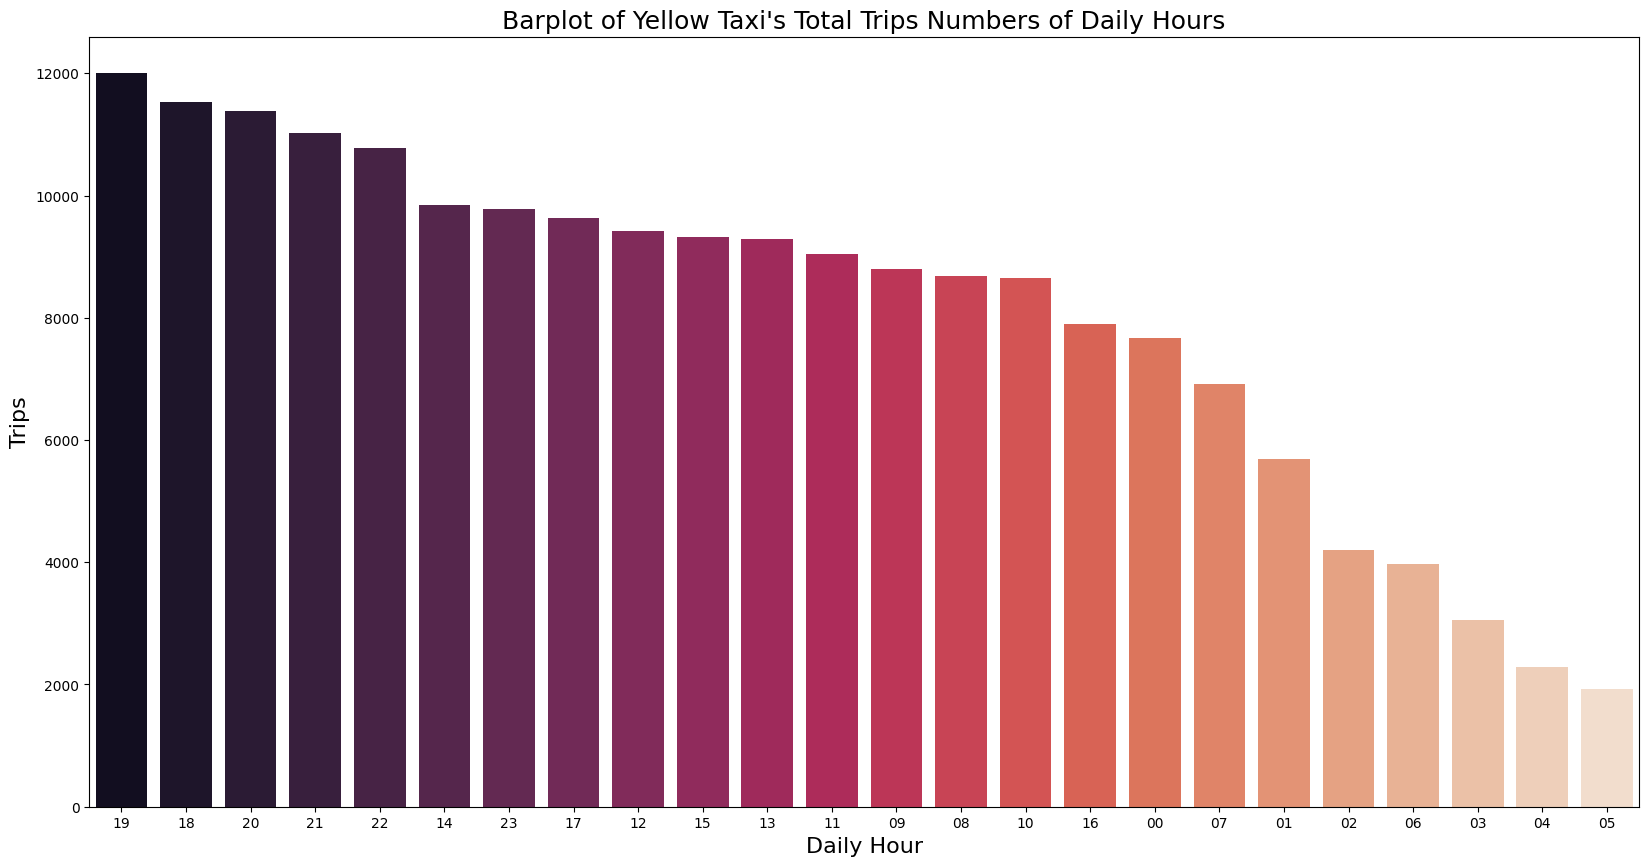

<IPython.core.display.Javascript object>

In [394]:
top_hour_taxi = get_data_for_taxi_trips()
plot_top_hour_taxi(top_hour_taxi)

### Visualization 2

Create a visualization of the 90% confidence interval and the mean of the average distance traveled per month.

In [395]:
def plot_avg_monthly_dist(dataframe):
    """Take in a dataframe containing distance data and create a confidence interval graph"""
    figure, axes = plt.subplots(figsize=(20, 10))

    z = 1.645
    horizontal_line_width = 0.2

    stats = dataframe.groupby(["month"])["distance"].agg(["mean", "sem"])
    stats["high"] = stats["mean"] + z * stats["sem"]
    stats["low"] = stats["mean"] - z * stats["sem"]

    for i in range(12):
        left = i + 1 - horizontal_line_width / 2
        top = stats["high"][i]
        right = i + 1 + horizontal_line_width / 2
        bottom = stats["low"][i]

        plt.plot([i + 1, i + 1], [top, bottom], color="lightpink")
        plt.plot([left, right], [top, top], color="lightpink")
        plt.plot([left, right], [bottom, bottom], color="lightpink")
        plt.plot(i + 1, stats["mean"][i], "o", color="salmon")

    plt.xticks(range(1, 13), dataframe["month"].unique())
    plt.xlabel("Month", fontsize=16)
    plt.ylabel("Distance/km", fontsize=16)

    plt.title(
        "Mean and 90% Confidence Interval of Monthly Traveled Distance", fontsize=18
    )
    plt.show()

<IPython.core.display.Javascript object>

In [402]:
def get_monthly_dist():
    """Retrieve the monthly traveled distance data from the database and return a dataframe"""
    AVG_MONTHLY_DIST = """
    WITH cte_monthly_dist AS (
    SELECT 
    strftime('%m',  pickup_datetime) AS month,
    distance
    FROM taxi_trips
    UNION ALL 
    SELECT 
    strftime('%m',  pickup_datetime) AS month,
    distance
    FROM uber_trips
    )
    
    SELECT month, distance
    FROM cte_monthly_dist
    ORDER BY month ASC
    
    """
    return pd.read_sql(AVG_MONTHLY_DIST, engine)

<IPython.core.display.Javascript object>

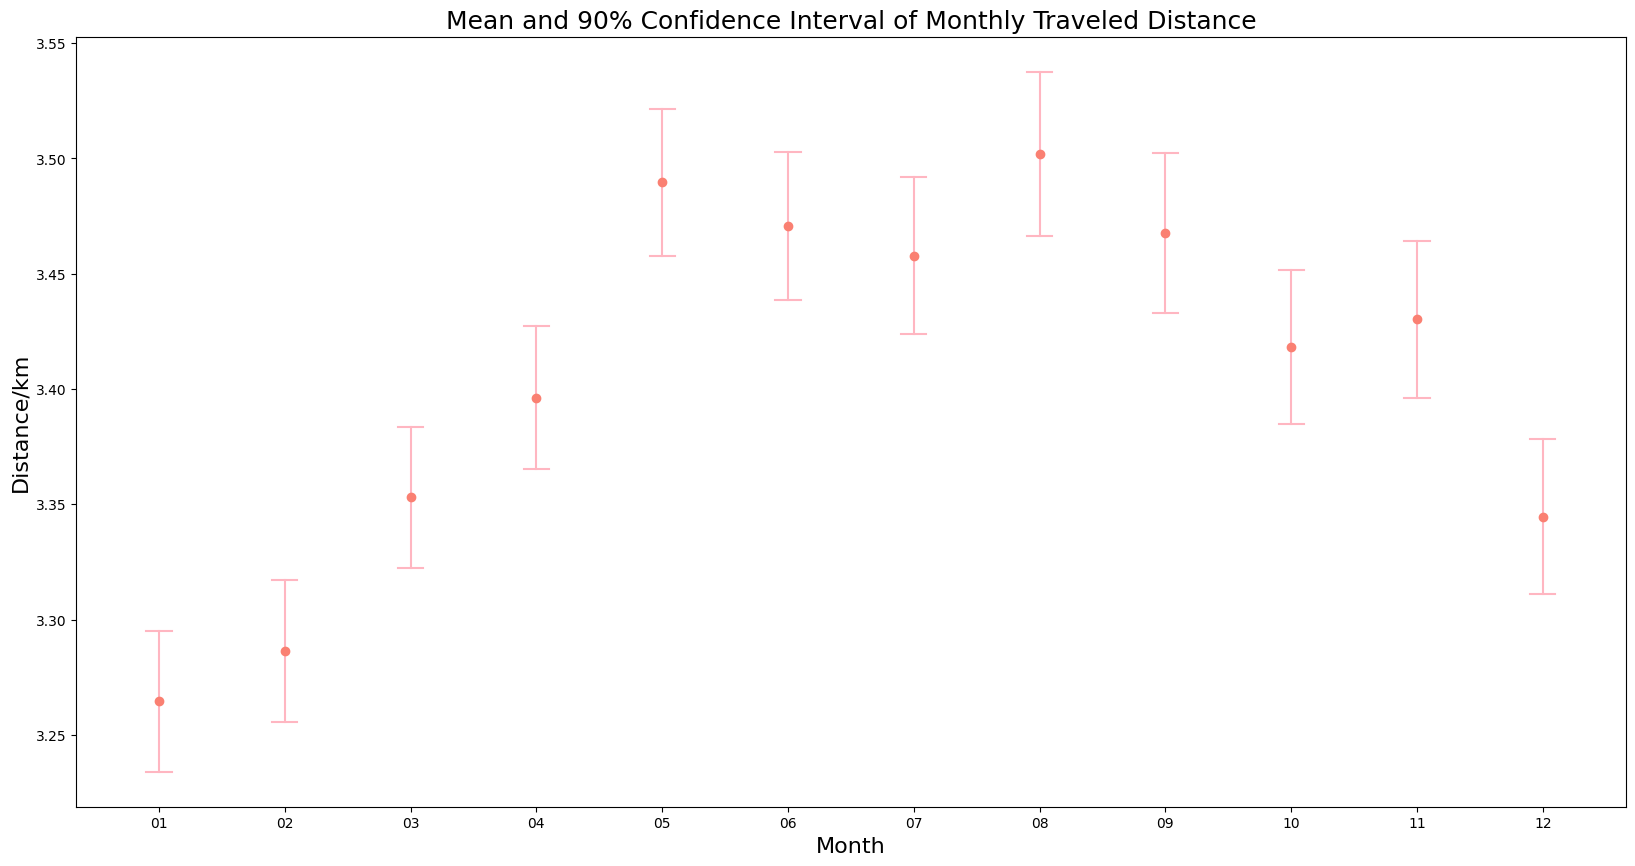

<IPython.core.display.Javascript object>

In [397]:
dist_mon = get_monthly_dist()
plot_avg_monthly_dist(dist_mon)

### Visualization 3

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR using bboxfinder and create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [361]:
def remove_trips_oustide_coord(lat1, lon1, lat2, lon2, df):
    """Take in the coordinates of the vertices and the dataframe to remove the dropoffs outside the required area"""
    # lat1 < lat2, lon1 < lon2
    df = df[(df["dropoff_latitude"] >= lat1) & (df["dropoff_latitude"] <= lat2)]
    df = df[(df["dropoff_longitude"] >= lon1) & (df["dropoff_longitude"] <= lon2)]

    return df

<IPython.core.display.Javascript object>

In [399]:
def plot_airport_dropoff(dataframe):
    """Take in the dataframe, determine the dropoff airport and plot the side-by-side bar chart"""
    figure, axes = plt.subplots(figsize=(20, 10))

    # define 3 coordinate boxes around LGA, JFK, EWR by bboxfinder
    LGA = [40.768089, -73.890587, 40.787588, -73.853851]
    JFK = [40.622465, -73.827567, 40.669354, -73.741050]
    EWR = [40.671293, -74.193137, 40.711643, -74.152453]

    # determining the dropoff location:
    # LGA
    df_LGA = remove_trips_oustide_coord(LGA[0], LGA[1], LGA[2], LGA[3], dataframe)
    df_LGA["airport"] = "LGA"
    # JFK
    df_JFK = remove_trips_oustide_coord(JFK[0], JFK[1], JFK[2], JFK[3], dataframe)
    df_JFK["airport"] = "JFK"
    # EWR
    df_EWR = remove_trips_oustide_coord(EWR[0], EWR[1], EWR[2], EWR[3], dataframe)
    df_EWR["airport"] = "EWR"

    new_df = pd.concat([df_LGA, df_JFK, df_EWR])

    sns.countplot(data=new_df, x="day", hue="airport", palette="rocket")
    axes.set_title("Countplot of Daily Drops of Three Airports", fontsize=18)
    axes.set_xlabel("Weekday", fontsize=16)
    axes.set_ylabel("Trips", fontsize=16)

    plt.show()

<IPython.core.display.Javascript object>

In [400]:
def get_dropoff_coord():
    """Retrieved the required dropoff data from the database and return in a dataframe"""
    DROPOFF_COORD = """
    WITH cte_dropoff_coord AS(
    SELECT 
    strftime('%w',  pickup_datetime) AS day,  
    dropoff_longitude,
    dropoff_latitude 
    FROM taxi_trips
    UNION ALL
    SELECT 
    strftime('%w',  pickup_datetime) AS day,
    dropoff_longitude,
    dropoff_latitude 
    FROM uber_trips
    )
    SELECT day, dropoff_longitude, dropoff_latitude  
    FROM cte_dropoff_coord
    ORDER BY day ASC
    """
    return pd.read_sql(DROPOFF_COORD, engine)

<IPython.core.display.Javascript object>

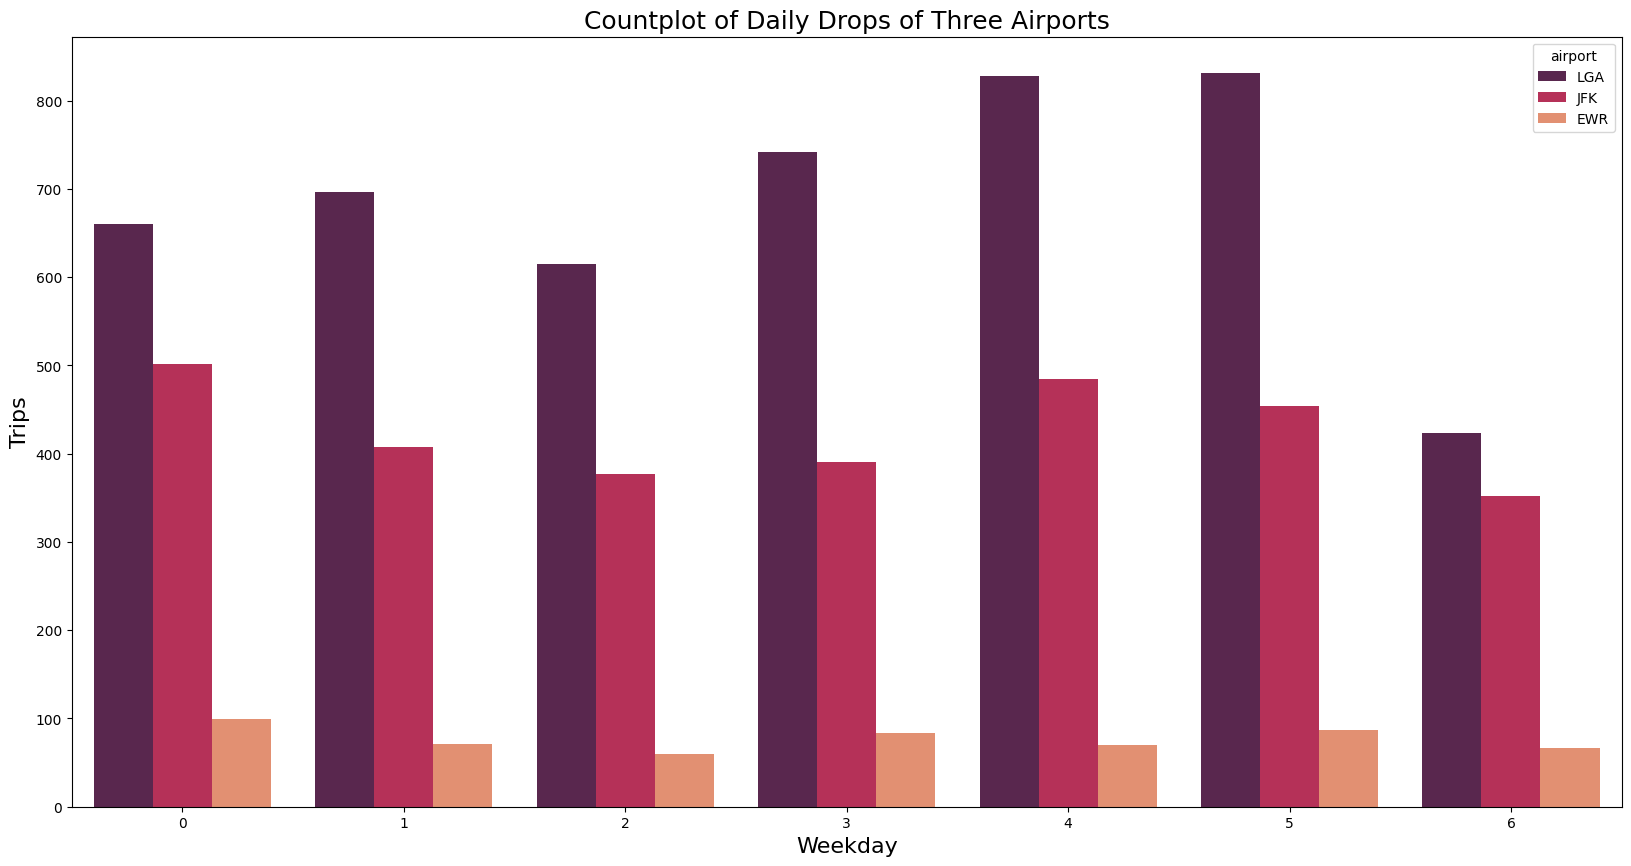

<IPython.core.display.Javascript object>

In [401]:
dropoff_coord = get_dropoff_coord()
plot_airport_dropoff(dropoff_coord)